![example](images/director_shot.jpeg)

## copy 2  9am sun 

Aurthor: Tori Magin 

This <span style="color:red">word</span> is not black.

## Overview & Business Problem

Microsoft sees big companies creating original video content and they want to do get in on the action. They've decided to a create a new movie studeio, but don’t know what type of movies they should make. 

Without a solid understanding of the current movie landscape, Microsoft will not be able to make confident decisions on content creation. Therefore, this analysis will use data from online data bases, IMDB and Box Office Mojo, to identify trends and highlight elements that typically make a movie successful. For example, does critical aclaim (high ratings) translate to higher revenue. 

*For this analysis 'success' is defined as box office revenue, i.e., 'gross'. 



## The Data & Method 

The data for this analysis came IMDB and Box Office Mojo as they have large databases, tracking many features of each movie. For exmaple, IMDB is able to collate a large number of online reviews from a wide variety of sources to provide a representative average rating. 

The IMDB data (includes two data sets - "Basics" and "Ratings") describes the movie titles, release year, genres, running time, and ratings for movies from 2010 to present including future releases. 

The Box Office Mojo data details the domestic (US) and foreign gross each movie earned from 2010 to 2018. 

Only movie data from 2015 to 2022 was analysed to focus on the most recent and relvant trends. The average ratings, genres, and runtimes were  compared against the movies' total gross (combined domestic(US) and foreign gross) to identify elements of success. 


In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
basics = pd.read_csv("data/zippedData/imdb.title.basics.csv.gz")
gross = pd.read_csv("data/zippedData/bom.movie_gross.csv.gz")
ratings = pd.read_csv("data/zippedData/imdb.title.ratings.csv.gz")

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [3]:
#The largest data set, IMDB Basics, was filtered to records from 2015 - 2022 to remove old data and future data which could be unreliable. 
basics['start_year_real']=pd.to_datetime(basics['start_year'], format='%Y')
recent_basics = basics.drop(basics[basics['start_year'] < 2015].index)

In [4]:
recent_basics = recent_basics.drop(recent_basics[recent_basics['start_year'] > 2022].index)

In [5]:
#IMDB Ratings was merged  onto IMDB Basics on 'tconst' the IMDB unique movie ID to make bnr (Basics 'n' Ratings). 
recent_basics = recent_basics.set_index('tconst')
ratings = ratings.set_index('tconst')

In [6]:
bnr = pd.merge(recent_basics,ratings, on=['tconst'],how='left') 

In [7]:
#To merge with Box Office Mojo's Movie Gross， the 'primary title' column was renames 'title' to provide a common column to merge. 
bnr.rename(columns = {'primary_title':'title'}, inplace = True)

In [8]:
#Gross was merged on to the new bnr data frame, however this new dataframe (bnr_2) had a lot of missing gross values. 
bnr_2 = pd.merge(bnr,gross, on=['title'],how='left') 

In [9]:
#Any records missing domestic_gross values were removed. Because ~80% of the records had no domestic_gross value, 
#they could not be reliably filled with placeholder values. 

bnr_2.dropna(subset=['domestic_gross'], inplace=True)

In [10]:
#It was considered to also drop all foreign_gross null values, but this would result it too much data loss and the percentage of missing values 
#was a more acceptable 43.7%, so it was decided to will the null values with the foreign_gross median. I did this by finding the median using the 
#original 'gross' dataset (it just made sense at the time and I got the info I needed, so didn't bother going back to do it the 'proper' way)
bnr_2['foreign_gross'].isna().sum() /  (bnr_2['foreign_gross'].count()+bnr_2['foreign_gross'].isna().sum())

In [11]:
gross.dropna(subset=['foreign_gross'], inplace=True)
gross['foreign_gross'] = gross['foreign_gross'].map(lambda x: x.replace(',',""))

In [12]:
gross.iloc[1300:1303]

,title,studio,domestic_gross,foreign_gross,year
1872,Star Wars: The Force Awakens,BV,936700000.0,1131.6,2015
1873,Jurassic World,Uni.,652300000.0,1019.4,2015
1874,Furious 7,Uni.,353000000.0,1163.0,2015


In [32]:
#Atfer removing the commas, the values can be converted to floats. However, it's clear these numbers are not correctly formatted. 
#Because there is only three, I manually replaced the values with the true foreign gross. 

gross['foreign_gross']= gross['foreign_gross'].replace([1131.6],1131561399)
gross['foreign_gross']= gross['foreign_gross'].replace([1019.4],1018130012)
gross['foreign_gross']= gross['foreign_gross'].replace([1163.0],1162040651)
gross.iloc[1300:1305]

,title,studio,domestic_gross,foreign_gross,year
1872,Star Wars: The Force Awakens,BV,936700000.0,1.131561e+09,2015
1873,Jurassic World,Uni.,652300000.0,1.018130e+09,2015
1874,Furious 7,Uni.,353000000.0,1.162041e+09,2015
1875,Avengers: Age of Ultron,BV,459000000.0,9.464000e+08,2015
1876,Minions,Uni.,336000000.0,8.234000e+08,2015


0.0

In [15]:
gross['foreign_gross']= gross['foreign_gross'].astype('float')
f_gross_median = gross['foreign_gross'].median()
bnr_2['foreign_gross'] = bnr_2['foreign_gross'].fillna(f_gross_median)

In [16]:
#The bnr_2 data set also had ',' values, these I replaced by moving the decimal point. 

In [17]:
bnr_2['foreign_gross']= bnr_2['foreign_gross'].replace(['1,131.6'],1131561399)
bnr_2['foreign_gross']= bnr_2['foreign_gross'].replace(['1,019.4'],1018130012)
bnr_2['foreign_gross']= bnr_2['foreign_gross'].replace(['1,163.0'],1162040651)
bnr_2['foreign_gross']= bnr_2['foreign_gross'].replace(['1,369.5'],1369500000)
bnr_2['foreign_gross']= bnr_2['foreign_gross'].replace(['1,010.0'],1010000000)

In [39]:
bnr_2['foreign_gross'] = bnr_2['foreign_gross'].astype('float')
bnr_2['total_gross'] = bnr_2['domestic_gross'] + bnr_2['foreign_gross']
#The domestic and foreign gross columns now both flost values with no null values, so analysis can begin. 
bnr_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 18 to 77239
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            1460 non-null   object        
 1   original_title   1460 non-null   object        
 2   start_year       1460 non-null   int64         
 3   runtime_minutes  1374 non-null   float64       
 4   genres           1460 non-null   object        
 5   start_year_real  1460 non-null   datetime64[ns]
 6   averagerating    1248 non-null   float64       
 7   numvotes         1248 non-null   float64       
 8   studio           1460 non-null   object        
 9   domestic_gross   1460 non-null   float64       
 10  foreign_gross    1460 non-null   float64       
 11  year             1460 non-null   float64       
 12  genreslist       1460 non-null   object        
 13  total_gross      1460 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int6

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [19]:
#26 records had no genre, so it is easiest to remove this small number of records with missing info. 
bnr_2= bnr_2.dropna(subset=['genres'])

In [20]:
#genres = bnr_2['genres']
#str(genres)

'18             Action,Crime,Drama\n29        Action,Adventure,Sci-Fi\n30                    Crime,Drama\n32        Biography,Drama,History\n43       Action,Adventure,Fantasy\n                   ...           \n76661                       Drama\n76726                       Drama\n76871                Action,Drama\n76901                       Crime\n77239                 Documentary\nName: genres, Length: 1460, dtype: object'

In [21]:
#genres1 = bnr_2['genres'].map(lambda x: x.split(', '))

In [35]:
bnr_2['genreslist'] = bnr_2['genres'].tolist()

In [36]:
print(bnr_2['genres'].map(lambda x: x.split(',')))

18             [Action, Crime, Drama]
29        [Action, Adventure, Sci-Fi]
30                     [Crime, Drama]
32        [Biography, Drama, History]
43       [Action, Adventure, Fantasy]
                     ...             
76661                         [Drama]
76726                         [Drama]
76871                 [Action, Drama]
76901                         [Crime]
77239                   [Documentary]
Name: genres, Length: 1460, dtype: object


## 1. Analysis by Ratings

Ratings of the top and bottom 100 movies (by total gross) were examined. 

In [121]:
by_gross = bnr_2.sort_values('total_gross', ascending=False)
top_100 = by_gross['total_gross'][0:100]
top_100 = list(top_100)

len(top_100)

100

In [87]:
best_100 = by_gross['averagerating'][0:100]
best_100 = list(best_100)

len(best_100)

100

In [88]:
bottom_gross = bnr_2.sort_values('total_gross')
bottom_100 = bottom_gross['total_gross'][0:100]
bottom_100 = list(bottom_100)

In [89]:
worst_100 = bottom_gross['averagerating'][0:100]
worst_100 = list(worst_100)

len(worst_100)

100

In [151]:
tops = pd.DataFrame()
tops['Gross'] = top_100
tops['AvgRatings'] = best_100

tops = tops.dropna()

TopRatingsCor = tops.corr(method='pearson')
TopRatingsCor

,Gross,AvgRatings
Gross,1.000000,0.329525
AvgRatings,0.329525,1.000000


In [148]:
CorrelationDF = pd.DataFrame()
CorrelationDF['gross'] = bnr_2['total_gross']
CorrelationDF['Avg_Rating'] = bnr_2['averagerating']
CorrelationDF['runtime'] = bnr_2['runtime_minutes']

CorrelationDF
correlation = CorrelationDF.corr(method='pearson')
correlation

,gross,Avg_Rating,runtime
gross,1.000000,0.135255,0.137843
Avg_Rating,0.135255,1.000000,0.198598
runtime,0.137843,0.198598,1.000000


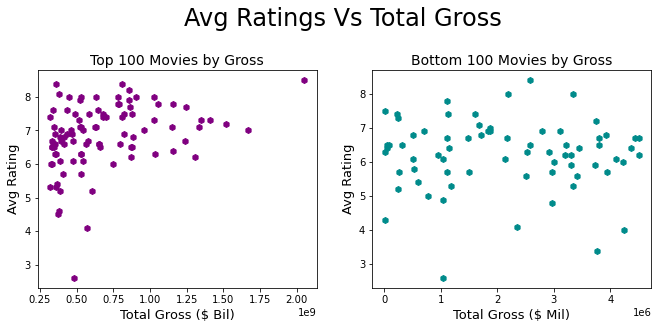

In [153]:
# Rating Vs Gross scatter plot was created to visualise possible relationship could be seen. 

fig, (ax1, ax2) = plt.subplots(figsize=(11,4), ncols=2)

ax1.scatter(x=top_100, y=best_100, color='purple', marker='h')
ax1.set_xlabel('Total Gross ($ Bil)', fontsize=13)
ax1.set_ylabel('Avg Rating',  fontsize=13)
ax1.set_title('Top 100 Movies by Gross', fontsize=14)


ax2.scatter(x=bottom_100, y=worst_100,color='darkcyan', marker='h')
ax2.set_xlabel('Total Gross ($ Mil)', fontsize=13)
ax2.set_ylabel('Avg Rating',  fontsize=13)
ax2.set_title('Bottom 100 Movies by Gross', fontsize=14)

fig.suptitle("Avg Ratings Vs Total Gross", fontsize=24, x=0.51, y=1.1)

plt.savefig('./images/RatingsGrossScatter.png', bbox_inches = "tight")


## 2. Analysis by Runtime 


In [93]:
top_by_runtime = bnr_2.sort_values('total_gross', ascending=False)
Time_top_100 = top_by_runtime['runtime_minutes'][0:100]
Time_top_100 = list(Time_top_100)

Top_Avg_Runtime = (str(sum(Time_top_100) / 100) + " mins")

Top_Avg_Runtime

'115.79 mins'

In [94]:
TopRuntime = pd.DataFrame()
TopRuntime['Gross'] = top_100
TopRuntime['Runtime'] = Time_top_100 

TopRuntime = TopRuntime.dropna()


In [95]:
bottom_by_runtime = bnr_2.sort_values('total_gross')
Time_bottom_100 = bottom_by_runtime['runtime_minutes'][0:100]
Time_bottom_100 = list(Time_bottom_100)


In [137]:
BottomsRuntime = pd.DataFrame()
BottomsRuntime['Gross'] = bottom_100
BottomsRuntime['Runtime'] = Time_bottom_100 

BottomsRuntime = BottomsRuntime.dropna()

Avg_Bottom_Runtime = BottomsRuntime['Runtime'].mean()
Avg_Bottom_Runtime

97.62790697674419

In [97]:
correlation = BottomsRuntime.corr(method='pearson')
correlation()

TypeError: 'DataFrame' object is not callable

Text(0.51, 1.1, 'Runtime Vs Gross')

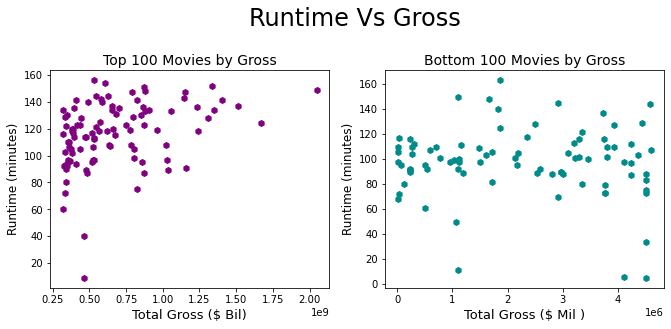

In [155]:
# Runtime Vs Gross
fig, (ax3, ax4) = plt.subplots(figsize=(11,4), ncols=2)

ax3.scatter(x=top_100, y=Time_top_100, color='purple', marker='h')
ax3.set_title('Top 100 Movies by Gross', fontsize = 14)
ax3.set_xlabel('Total Gross ($ Bil)', fontsize = 13)
ax3.set_ylabel('Runtime (minutes)', fontsize = 12)


ax4.scatter(x=bottom_100, y=Time_bottom_100,color='darkcyan', marker='h')
ax4.set_title('Bottom 100 Movies by Gross', fontsize = 14)
ax4.set_xlabel('Total Gross ($ Mil )', fontsize = 13)
ax4.set_ylabel('Runtime (minutes)', fontsize = 12)

plt.savefig('./images/RuntimeGrossScatter.png', bbox_inches = "tight")

fig.suptitle("Runtime Vs Gross", fontsize=24, x=0.51, y=1.1)


## 3. Analysis by Genre 


In [99]:
bnr_by_gross = bnr_2.sort_values('total_gross', ascending=False)
bnr_top100_by_gross = bnr_by_gross[0:100]


In [100]:
Top_genres = ""
for x in bnr_top100_by_gross['genreslist']:
    Top_genres += str(x) + ","
Top_genres = Top_genres.split(',')

len(Top_genres)

287

In [168]:
from collections import Counter
top_counts_average = Counter(Top_genres).most_common()
print(top_counts_average)
type(top_counts_average)

[('Adventure', 69), ('Action', 58), ('Comedy', 35), ('Animation', 24), ('Sci-Fi', 20), ('Drama', 18), ('Fantasy', 15), ('Thriller', 13), ('Horror', 6), ('Documentary', 5), ('Family', 4), ('Romance', 4), ('Biography', 3), ('Mystery', 3), ('Crime', 2), ('Music', 2), ('History', 2), ('Musical', 2), ('Sport', 1), ('', 1)]


list

In [102]:
top_names = []
for x in top_counts_average:
    top_names.append(x[0])

In [103]:
top_values = []
for x in top_counts_average:
    top_values.append(x[1])
top_values

[69, 58, 35, 24, 20, 18, 15, 13, 6, 5, 4, 4, 3, 3, 2, 2, 2, 2, 1, 1]

In [104]:
bnr_by_gross_bottom = bnr_2.sort_values('total_gross')
bnr_bottom100_by_gross = bnr_by_gross_bottom[0:100]

len(bnr_bottom100_by_gross)

100

In [105]:
bottom_genres = ""
for x in bnr_bottom100_by_gross['genreslist']:
    bottom_genres += str(x) + ","
bottom_genres = bottom_genres.split(',')

len(bottom_genres)

200

In [106]:
from collections import Counter
bottom_counts_average = Counter(bottom_genres).most_common()
bottom_counts_average = bottom_counts_average[0:20]
len(bottom_counts_average)


20

In [107]:
bottom_names = []
for x in bottom_counts_average:
    bottom_names.append(x[0])

bottom_names = bottom_names[0:20]

In [108]:
bottom_values = []
for x in bottom_counts_average:
    bottom_values.append(x[1])

bottom_values = bottom_values[0:20]
print(bottom_names)
print(bottom_values)

['Drama', 'Documentary', 'Comedy', 'Thriller', 'Biography', 'Romance', 'Horror', 'Mystery', 'Music', 'Action', 'War', 'Family', 'Adventure', 'History', 'Crime', 'Fantasy', 'Animation', 'Sci-Fi', 'Sport', 'Western']
[57, 22, 21, 14, 14, 12, 8, 8, 7, 6, 5, 5, 5, 4, 3, 3, 2, 1, 1, 1]


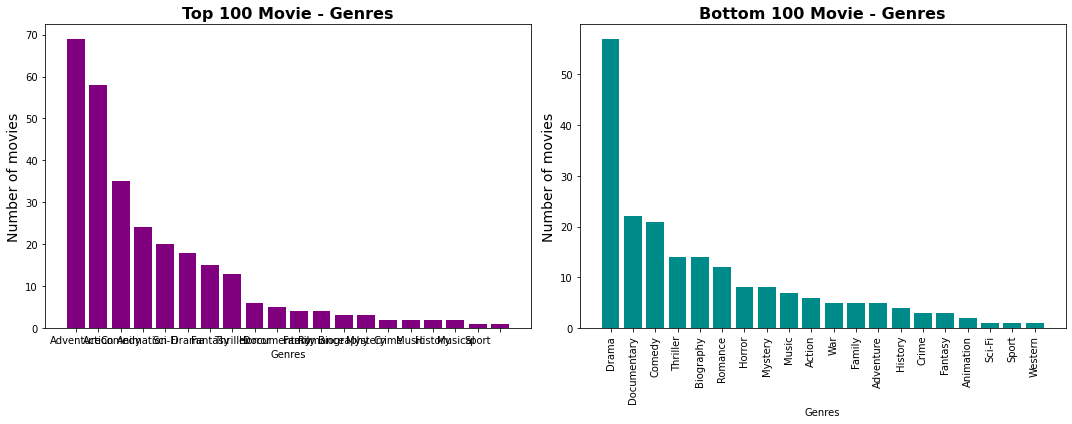

Text(0.5, 0.98, 'Common Genres for the Top & Bottom Movie Lists')

In [165]:
fig, (gt,gb) = plt.subplots(figsize=(15,6), ncols=2)

gt.bar(range(len(top_counts_average)), top_values, color=('purple'), tick_label=top_names)
plt.xticks(rotation = 90)
gt.set_ylabel('Number of movies', fontsize=14)
gt.set_xlabel('Genres')
gt.set_title('Top 100 Movie - Genres', fontweight="bold", fontsize =16)


gb.bar(range(len(bottom_counts_average)), bottom_values,color=('darkcyan'), tick_label=bottom_names)
plt.xticks(rotation=90)
gb.set_ylabel('Number of movies', fontsize=14)
gb.set_xlabel('Genres')
gb.set_title('Bottom 100 Movie - Genres', fontweight="bold",  fontsize =16)
fig.tight_layout()
plt.savefig('./images/Genres_Top_n_Bottom.png', bbox_inches = "tight")
plt.show();

fig.suptitle('Common Genres for the Top & Bottom Movie Lists', fontsize = '24')

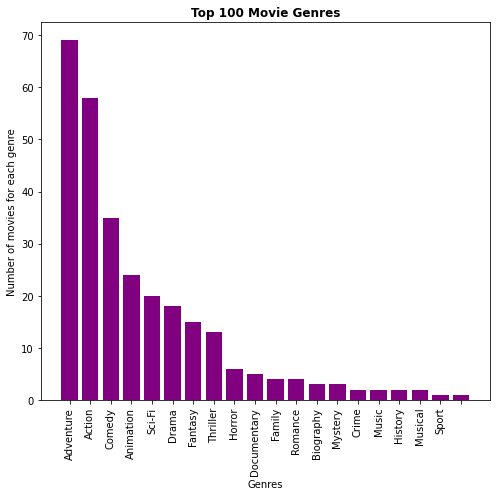

In [132]:
fig, gt = plt.subplots(figsize=(7.,7))
barlist=plt.bar(range(len(top_counts_average)), top_values, color=('purple'), tick_label=top_names)
plt.xticks(rotation=90)
gt.set_ylabel('Number of movies for each genre')
gt.set_xlabel('Genres')
gt.set_title('Top 100 Movie Genres', fontweight="bold")
fig.tight_layout()
plt.savefig('./images/top20_IMDB_genres.png', bbox_inches = "tight")
plt.show();

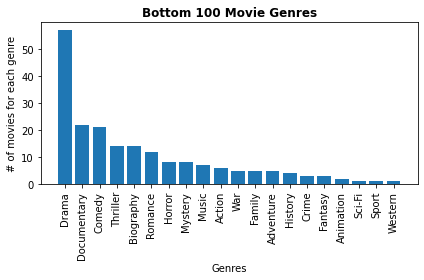

In [80]:
fig, gb = plt.subplots()
bottom_genres_bar=plt.bar(range(len(bottom_counts_average)), bottom_values, tick_label=bottom_names)
plt.xticks(rotation=90)
gb.set_ylabel('# of movies for each genre')
gb.set_xlabel('Genres')
gb.set_title('Bottom 100 Movie Genres', fontweight="bold")
fig.tight_layout()
plt.savefig('./images/top20_IMDB_genres.png', bbox_inches = "tight")
plt.show();

In [167]:
Top_studios = ""
for x in bnr_top100_by_gross['studio']:
    Top_studios += str(x) + ","
Top_studios = Top_studios.split(',')

len(Top_studios)

101

In [169]:
from collections import Counter
topS_counts_average = Counter(Top_studios).most_common()
print(topS_counts_average)
type(topS_counts_average)

[('BV', 24), ('Uni.', 20), ('Fox', 15), ('WB', 14), ('Par.', 8), ('Sony', 7), ('WB (NL)', 4), ('LGF', 2), ('LG/S', 2), ('HC', 1), ('WGUSA', 1), ('FR', 1), ('FUN', 1), ('', 1)]


list

In [174]:
topS_names = []
for x in topS_counts_average:
    topS_names.append(x[0])
len(topS_names)

14

In [173]:
topS_values = []
for x in topS_counts_average:
    topS_values.append(x[1])
len(topS_values)

14

In [193]:
Bottom_studios = ""
for x in bnr_bottom100_by_gross['studio']:
    Bottom_studios += str(x) + ","
Bottom_studios = Bottom_studios.split(',')

len(Bottom_studios)

101

In [194]:
from collections import Counter
bottomS_counts_average = Counter(Bottom_studios).most_common()
print(bottomS_counts_average)
type(bottomS_counts_average)

[('RAtt.', 12), ('IFC', 9), ('CGld', 5), ('MBox', 5), ('Strand', 4), ('Magn.', 4), ('FIP', 4), ('UTV', 3), ('DR', 3), ('A24', 3), ('Uni.', 3), ('SPC', 3), ('FM', 2), ('Wein.', 2), ('Osci.', 2), ('FoxS', 2), ('LGF', 2), ('Sony', 2), ('Hann.', 2), ('MNE', 2), ('Cohen', 2), ('ParV', 2), ('AF', 2), ('FRun', 1), ('NYer', 1), ('Grindstone', 1), ('NAV', 1), ('Mira.', 1), ('KL', 1), ('Vita.', 1), ('BG', 1), ('MOM', 1), ('Orch.', 1), ('FR', 1), ('Zee', 1), ('Zeit.', 1), ('VE', 1), ('STX', 1), ('Aviron', 1), ('Annapurna', 1), ('Fox', 1), ('Scre.', 1), ('WGUSA', 1), ('', 1)]


list

In [195]:
bottomS_names = []
for x in bottomS_counts_average:
    bottomS_names.append(x[0])
len(bottomS_names)

44

In [196]:
bottomS_values = []
for x in bottomS_counts_average:
    bottomS_values.append(x[1])
len(bottomS_values)

44

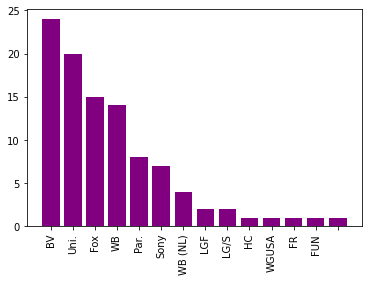

In [199]:
Top = plt.bar(range(len(topS_counts_average)), topS_values, color=('purple'), tick_label=topS_names)
plt.xticks(rotation=90)
ts.set_ylabel('Number of movies')
ts.set_xlabel('Studio Name')
ts.set_title('Top 100 Movie - Studio', fontweight="bold", fontsize = 15)
fig.tight_layout()

Text(0.5, 1.0, 'Bottom 100 Movie - Studio')

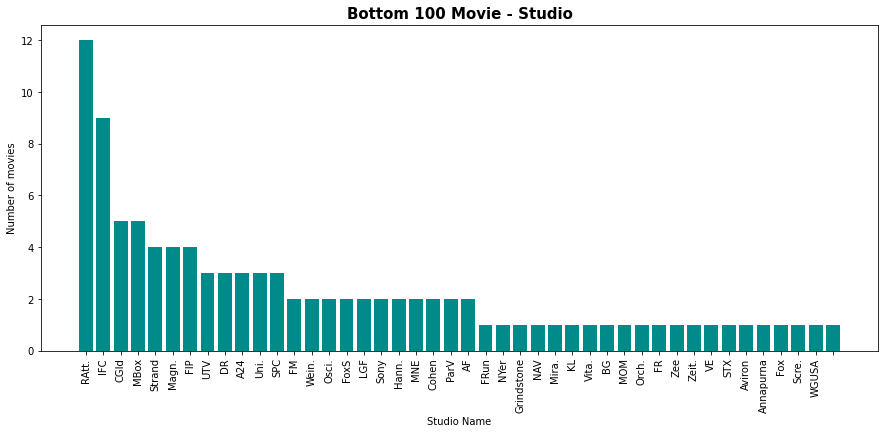

In [203]:
fig, bs = plt.subplots(figsize=(15,6), ncols=1)
bottom =plt.bar(range(len(bottomS_counts_average)), bottomS_values, color=('darkcyan'), tick_label=bottomS_names)
plt.xticks(rotation=90)
bs.set_ylabel('Number of movies')
bs.set_xlabel('Studio Name')
bs.set_title('Bottom 100 Movie - Studio', fontweight="bold", fontsize = 15)


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***